In [34]:
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, optimizers, preprocessing, initializers
from tensorflow.keras.layers import MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten, InputLayer, Conv2D, Activation
import tensorflow as tf
from tensorflow.python.keras import backend as K
from sklearn import preprocessing, model_selection
from math import ceil
import pandas as pd
import numpy as np
from skimage import io
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from scipy.stats import hmean
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
class BatchGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([preprocessing.StandardScaler().fit_transform(io.imread(os.path.join(PATH, file_name))).reshape(
            (400, 400, 1))
                         for file_name in batch_x]), np.array(batch_y)



In [4]:
def create_model(filters, learning_rate, dropout0, dropout1, activation):
    model = Sequential()
    model.add(Conv2D(filters[0], kernel_size=(5, 5), input_shape=(400, 400, 1),
                     kernel_initializer=initializers.GlorotNormal(), padding="same"))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    for index, filter_ in enumerate(filters[1:-2]):
        model.add(Conv2D(filter_, kernel_size=(3, 3), activation=activation, padding="same"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(filters[-2]))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout0))

    model.add(Dense(filters[-1]))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout1))

    model.add(Dense(4, activation='softmax'))

    opt = optimizers.Adam(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt,
                  metrics=['categorical_accuracy'])

    return model

In [5]:
dim_layer0 = Categorical([8, 16, 32], name="layer0")
dim_layer1 = Categorical([16, 32, 64], name="layer1")
dim_layer2 = Categorical([32, 64], name="layer2")
dim_layer3 = Categorical([64, 128], name="layer3")
dim_layer4 = Categorical([64, 128], name="layer4")
dim_layer5 = Categorical([16, 32, 64], name="layer5")
dim_layer6 = Categorical([8, 16, 32, 64], name="layer6")

dim_learning_rate = Real(low=0.0005, high=0.05, prior="log-uniform", name="learning_rate")
dim_dropout_0 = Real(low=0.1, high=0.5, prior="log-uniform", name="dropout0")
dim_dropout_1 = Real(low=0.1, high=0.3, prior="log-uniform", name="dropout1")
dim_activation = Categorical(["relu", "tanh", "sigmoid"], name="activation")
dim_batch_size = Categorical([16, 32, 64], name="batch_size")
#dim_num_layers = Integer(low=4, high=8, name="num_layer")

dimensions = [dim_layer0, dim_layer2, dim_layer3, dim_layer4, dim_layer5, dim_layer6,
              dim_learning_rate, dim_dropout_0, dim_dropout_1, dim_activation, dim_batch_size]
defaults = [16, 32, 64, 128, 128, 8, 0.0026, 0.4, 0.3, "relu", 64]

In [6]:
@use_named_args(dimensions=dimensions)
def fitness(**kargs):
    global X, Y
    #num_layers = kargs["num_layers"]
    filters = [kargs[key] for key in kargs.keys() if key.startswith("layer")]
    learning_rate = kargs["learning_rate"]
    activation = kargs["activation"]
    dropout0 = kargs["dropout0"]
    dropout1 = kargs["dropout1"]
    batch_size = kargs["batch_size"]
    print("Filters: {}\nLearnig Rate: {}\nActivation: {}\nDropout 0: {}\nDropout 1: {}\nBatch size: {}".format(filters, learning_rate, activation, dropout0, dropout1, batch_size))
    
    list_acc = []
    sss = model_selection.StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=1)
    for index_iter, indexes_split  in enumerate(sss.split(X, Y)):
        train_index, test_index = indexes_split
        print("\nSplit {}".format(index_iter))
        
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = pd.get_dummies(Y[train_index]).values, pd.get_dummies(Y[test_index]).values
        train_batch_generator = BatchGenerator(x_train, y_train, batch_size=batch_size)
        test_batch_generator = BatchGenerator(x_test, y_test, batch_size=batch_size)
        try:
            model = create_model(filters=filters, learning_rate=learning_rate, 
                                 dropout0=dropout0, dropout1=dropout1, activation=activation)
            history = model.fit(x=train_batch_generator, verbose=1, epochs=5,
                                validation_data=test_batch_generator, validation_freq=[5])
            list_acc.append(history.history['val_categorical_accuracy'])
            del(model)
        except tf.errors.ResourceExhaustedError:
            print("\nCNN very large!")
            if "model" in locals():
                del(model)
            break
            
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    
    if list_acc:
        acc = hmean(list_acc)[0]
    else:
        acc = -100
    
    print("\nAcc: {}\n".format(acc))

    return -acc

In [7]:
PATH = os.path.join("dataset", "data_augmented")
df = pd.read_csv("dataset/name_data_augmented.csv", index_col=0)
X = df.filename.values
Y = df.label.values

In [9]:
gp_result_1 = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=50,
                            verbose=1,
                            noise= 0.01,
                           x0=defaults)

Iteration No: 1 started. Evaluating function at provided point.
Filters: [16, 32, 64, 128, 128, 8]
Learnig Rate: 0.0026
Activation: relu
Dropout 0: 0.4
Dropout 1: 0.3
Batch size: 64

Split 0
Train for 225 steps, validate for 25 steps
Epoch 1/5
225/225 [==============================] - 161s 715ms/step - loss: 0.6553 - categorical_accuracy: 0.7617
Epoch 2/5
225/225 [==============================] - 107s 476ms/step - loss: 0.2866 - categorical_accuracy: 0.9031
Epoch 3/5
225/225 [==============================] - 105s 466ms/step - loss: 0.2263 - categorical_accuracy: 0.9232
Epoch 4/5
225/225 [==============================] - 104s 464ms/step - loss: 0.1671 - categorical_accuracy: 0.9416
Epoch 5/5
225/225 [==============================] - 124s 553ms/step - loss: 0.1321 - categorical_accuracy: 0.9526 - val_loss: 0.1625 - val_categorical_accuracy: 0.9580

Split 1
Train for 225 steps, validate for 25 steps
Epoch 1/5
225/225 [==============================] - 107s 475ms/step - loss: 0.6414 -

449/449 [==============================] - 108s 241ms/step - loss: 0.2660 - categorical_accuracy: 0.9071
Epoch 4/5
449/449 [==============================] - 108s 240ms/step - loss: 0.2198 - categorical_accuracy: 0.9191
Epoch 5/5
449/449 [==============================] - 120s 268ms/step - loss: 0.1950 - categorical_accuracy: 0.9294 - val_loss: 0.5886 - val_categorical_accuracy: 0.7898

Acc: 0.8348013162612915

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1112.2952
Function value obtained: -0.8348
Current minimum: -0.9481
Iteration No: 6 started. Evaluating function at random point.
Filters: [32, 64, 64, 64, 16, 8]
Learnig Rate: 0.0035487582854980605
Activation: sigmoid
Dropout 0: 0.1152539311279802
Dropout 1: 0.10346535078257724
Batch size: 64

Split 0
Train for 225 steps, validate for 25 steps
Epoch 1/5
  1/225 [..............................] - ETA: 59:16
CNN very large!

Acc: -100

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.2129
Fu

Train for 897 steps, validate for 100 steps
Epoch 1/5
897/897 [==============================] - 113s 126ms/step - loss: 0.4268 - categorical_accuracy: 0.8371
Epoch 2/5
897/897 [==============================] - 112s 124ms/step - loss: 0.2189 - categorical_accuracy: 0.9246
Epoch 3/5
897/897 [==============================] - 111s 124ms/step - loss: 0.1765 - categorical_accuracy: 0.9393
Epoch 4/5
897/897 [==============================] - 111s 124ms/step - loss: 0.1388 - categorical_accuracy: 0.9515
Epoch 5/5
897/897 [==============================] - 123s 138ms/step - loss: 0.1117 - categorical_accuracy: 0.9624 - val_loss: 0.3899 - val_categorical_accuracy: 0.8639

Split 1
Train for 897 steps, validate for 100 steps
Epoch 1/5
897/897 [==============================] - 113s 126ms/step - loss: 0.4161 - categorical_accuracy: 0.8380
Epoch 2/5
897/897 [==============================] - 111s 124ms/step - loss: 0.2314 - categorical_accuracy: 0.9202
Epoch 3/5
897/897 [=========================


Split 1
Train for 449 steps, validate for 50 steps
Epoch 1/5
449/449 [==============================] - 111s 246ms/step - loss: 0.4513 - categorical_accuracy: 0.8397
Epoch 2/5
449/449 [==============================] - 109s 244ms/step - loss: 0.1882 - categorical_accuracy: 0.9388
Epoch 3/5
449/449 [==============================] - 108s 241ms/step - loss: 0.1171 - categorical_accuracy: 0.9611
Epoch 4/5
449/449 [==============================] - 108s 241ms/step - loss: 0.0843 - categorical_accuracy: 0.9722
Epoch 5/5
449/449 [==============================] - 120s 266ms/step - loss: 0.0653 - categorical_accuracy: 0.9773 - val_loss: 0.1930 - val_categorical_accuracy: 0.9391

Acc: 0.9419615268707275

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1116.4970
Function value obtained: -0.9420
Current minimum: -0.9481
Iteration No: 17 started. Searching for the next optimal point.
Filters: [32, 32, 64, 32, 16, 8]
Learnig Rate: 0.0005
Activation: relu
Dropout 0:


Acc: 0.49973466992378235

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1151.2945
Function value obtained: -0.4997
Current minimum: -0.9481
Iteration No: 22 started. Searching for the next optimal point.
Filters: [16, 32, 128, 128, 128, 16]
Learnig Rate: 0.0241946020506553
Activation: tanh
Dropout 0: 0.23731696123187868
Dropout 1: 0.1372379643849975
Batch size: 32

Split 0
Train for 449 steps, validate for 50 steps
Epoch 1/5
449/449 [==============================] - 111s 247ms/step - loss: 0.5284 - categorical_accuracy: 0.7905
Epoch 2/5
449/449 [==============================] - 109s 244ms/step - loss: 0.4027 - categorical_accuracy: 0.8456
Epoch 3/5
449/449 [==============================] - 109s 243ms/step - loss: 0.4142 - categorical_accuracy: 0.8405
Epoch 4/5
449/449 [==============================] - 110s 245ms/step - loss: 0.4375 - categorical_accuracy: 0.8304
Epoch 5/5
449/449 [==============================] - 121s 270ms/step - loss: 0.6815 - 

449/449 [==============================] - 110s 244ms/step - loss: 0.4836 - categorical_accuracy: 0.8080
Epoch 2/5
449/449 [==============================] - 108s 241ms/step - loss: 0.2588 - categorical_accuracy: 0.9030
Epoch 3/5
449/449 [==============================] - 108s 239ms/step - loss: 0.1967 - categorical_accuracy: 0.9269
Epoch 4/5
449/449 [==============================] - 108s 241ms/step - loss: 0.1623 - categorical_accuracy: 0.9418
Epoch 5/5
449/449 [==============================] - 121s 269ms/step - loss: 0.1324 - categorical_accuracy: 0.9490 - val_loss: 0.5994 - val_categorical_accuracy: 0.8300

Acc: 0.8584615588188171

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1114.7922
Function value obtained: -0.8585
Current minimum: -0.9514
Iteration No: 27 started. Searching for the next optimal point.
Filters: [16, 64, 128, 64, 16, 8]
Learnig Rate: 0.0013751771111753265
Activation: tanh
Dropout 0: 0.33096390010943566
Dropout 1: 0.138855607507

449/449 [==============================] - 113s 252ms/step - loss: 0.8589 - categorical_accuracy: 0.7085
Epoch 2/5
449/449 [==============================] - 111s 247ms/step - loss: 0.4902 - categorical_accuracy: 0.8730
Epoch 3/5
449/449 [==============================] - 110s 244ms/step - loss: 0.2978 - categorical_accuracy: 0.9294
Epoch 4/5
449/449 [==============================] - 110s 245ms/step - loss: 0.1761 - categorical_accuracy: 0.9658
Epoch 5/5
449/449 [==============================] - 121s 270ms/step - loss: 0.1088 - categorical_accuracy: 0.9823 - val_loss: 2.2649 - val_categorical_accuracy: 0.5659

Split 1
Train for 449 steps, validate for 50 steps
Epoch 1/5
449/449 [==============================] - 111s 247ms/step - loss: 0.8738 - categorical_accuracy: 0.6931
Epoch 2/5
449/449 [==============================] - 111s 248ms/step - loss: 0.4837 - categorical_accuracy: 0.8728
Epoch 3/5
449/449 [==============================] - 110s 245ms/step - loss: 0.2931 - categorical_a

449/449 [==============================] - 121s 269ms/step - loss: 0.0500 - categorical_accuracy: 0.9821 - val_loss: 0.4722 - val_categorical_accuracy: 0.8946

Acc: 0.9228554368019104

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1193.2947
Function value obtained: -0.9229
Current minimum: -0.9514
Iteration No: 36 started. Searching for the next optimal point.
Filters: [16, 32, 128, 64, 128, 32]
Learnig Rate: 0.0005
Activation: relu
Dropout 0: 0.4423668200665378
Dropout 1: 0.29999999999999993
Batch size: 32

Split 0
Train for 449 steps, validate for 50 steps
Epoch 1/5
449/449 [==============================] - 110s 246ms/step - loss: 0.5506 - categorical_accuracy: 0.8095
Epoch 2/5
449/449 [==============================] - 109s 243ms/step - loss: 0.2068 - categorical_accuracy: 0.9415
Epoch 3/5
449/449 [==============================] - 109s 243ms/step - loss: 0.1202 - categorical_accuracy: 0.9649
Epoch 4/5
449/449 [==============================] - 110

897/897 [==============================] - 124s 138ms/step - loss: 0.0377 - categorical_accuracy: 0.9875 - val_loss: 0.8389 - val_categorical_accuracy: 0.8118

Split 1
Train for 897 steps, validate for 100 steps
Epoch 1/5
897/897 [==============================] - 113s 126ms/step - loss: 0.4425 - categorical_accuracy: 0.8341
Epoch 2/5
897/897 [==============================] - 112s 124ms/step - loss: 0.1815 - categorical_accuracy: 0.9369
Epoch 3/5
897/897 [==============================] - 112s 124ms/step - loss: 0.0941 - categorical_accuracy: 0.9692
Epoch 4/5
897/897 [==============================] - 112s 125ms/step - loss: 0.0594 - categorical_accuracy: 0.9811
Epoch 5/5
897/897 [==============================] - 124s 138ms/step - loss: 0.0356 - categorical_accuracy: 0.9895 - val_loss: 0.3247 - val_categorical_accuracy: 0.9134

Acc: 0.859616219997406

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1150.1229
Function value obtained: -0.8596
Current min

Train for 225 steps, validate for 25 steps
Epoch 1/5
225/225 [==============================] - 108s 482ms/step - loss: 0.8289 - categorical_accuracy: 0.6972
Epoch 2/5
225/225 [==============================] - 107s 474ms/step - loss: 0.4571 - categorical_accuracy: 0.8502
Epoch 3/5
225/225 [==============================] - 106s 473ms/step - loss: 0.3464 - categorical_accuracy: 0.8823
Epoch 4/5
225/225 [==============================] - 107s 476ms/step - loss: 0.2673 - categorical_accuracy: 0.9107
Epoch 5/5
225/225 [==============================] - 119s 529ms/step - loss: 0.2232 - categorical_accuracy: 0.9284 - val_loss: 0.5019 - val_categorical_accuracy: 0.8494

Split 1
Train for 225 steps, validate for 25 steps
Epoch 1/5
225/225 [==============================] - 109s 485ms/step - loss: 0.9969 - categorical_accuracy: 0.6210
Epoch 2/5
225/225 [==============================] - 107s 473ms/step - loss: 0.5033 - categorical_accuracy: 0.8480
Epoch 3/5
225/225 [===========================

449/449 [==============================] - 190s 423ms/step - loss: 0.2273 - categorical_accuracy: 0.9760 - val_loss: 0.5283 - val_categorical_accuracy: 0.8752

Acc: 0.8672439455986023

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1354.0563
Function value obtained: -0.8672
Current minimum: -0.9514
Iteration No: 50 started. Searching for the next optimal point.
Filters: [16, 32, 128, 128, 32, 8]
Learnig Rate: 0.0005
Activation: relu
Dropout 0: 0.49999999999999994
Dropout 1: 0.29999999999999993
Batch size: 32

Split 0
Train for 449 steps, validate for 50 steps
Epoch 1/5
449/449 [==============================] - 209s 465ms/step - loss: 0.8974 - categorical_accuracy: 0.6744
Epoch 2/5
449/449 [==============================] - 177s 393ms/step - loss: 0.5638 - categorical_accuracy: 0.8017
Epoch 3/5
449/449 [==============================] - 159s 354ms/step - loss: 0.4527 - categorical_accuracy: 0.8296
Epoch 4/5
449/449 [==============================] - 122

In [10]:
gp_result_1.x

[16,
 32,
 128,
 128,
 32,
 8,
 0.0005,
 0.49999999999999994,
 0.29999999999999993,
 'relu',
 32]

In [22]:
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
batch_size = 32
acc_list = []
for index_fold, index_data in enumerate(kfold.split(X, Y)):
    print("Training fold {}".format(index_fold))
    train_index, test_index = index_data
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = pd.get_dummies(Y[train_index]).values, pd.get_dummies(Y[test_index]).values
    train_batch_generator = BatchGenerator(x_train, y_train, batch_size=batch_size)
    test_batch_generator = BatchGenerator(x_test, y_test, batch_size=batch_size)
    
    model = create_model(filters=[16, 32, 128, 128, 32, 8], learning_rate=0.0005, activation="relu", 
                         dropout0=0.5, dropout1=0.3)
    result = model.fit(x=train_batch_generator, verbose=1, epochs=8, 
                       validation_data=test_batch_generator, validation_freq=[8])
    acc = result.history['val_categorical_accuracy'][0]
    print("Acc: {:.3f}\n".format(acc))
    acc_list.append(acc)
    del(model)      
    K.clear_session()
    tf.compat.v1.reset_default_graph()

Training fold 0
Train for 449 steps, validate for 50 steps
Epoch 1/8
449/449 [==============================] - 224s 499ms/step - loss: 0.8541 - categorical_accuracy: 0.6546
Epoch 2/8
449/449 [==============================] - 114s 253ms/step - loss: 0.5309 - categorical_accuracy: 0.8173
Epoch 3/8
449/449 [==============================] - 120s 268ms/step - loss: 0.4131 - categorical_accuracy: 0.8479
Epoch 4/8
449/449 [==============================] - 126s 280ms/step - loss: 0.3486 - categorical_accuracy: 0.8625
Epoch 5/8
449/449 [==============================] - 121s 269ms/step - loss: 0.2990 - categorical_accuracy: 0.8781
Epoch 6/8
449/449 [==============================] - 123s 273ms/step - loss: 0.2656 - categorical_accuracy: 0.8830
Epoch 7/8
449/449 [==============================] - 123s 273ms/step - loss: 0.2518 - categorical_accuracy: 0.8874
Epoch 8/8
449/449 [==============================] - 153s 341ms/step - loss: 0.2194 - categorical_accuracy: 0.8961 - val_loss: 0.2738 - 

449/449 [==============================] - 128s 284ms/step - loss: 0.2224 - categorical_accuracy: 0.9050 - val_loss: 0.1917 - val_categorical_accuracy: 0.9341
Acc: 0.934

Training fold 8
Train for 449 steps, validate for 50 steps
Epoch 1/8
449/449 [==============================] - 115s 255ms/step - loss: 0.8728 - categorical_accuracy: 0.6702
Epoch 2/8
449/449 [==============================] - 116s 258ms/step - loss: 0.5712 - categorical_accuracy: 0.8149
Epoch 3/8
449/449 [==============================] - 115s 257ms/step - loss: 0.4284 - categorical_accuracy: 0.8441
Epoch 4/8
449/449 [==============================] - 115s 256ms/step - loss: 0.3562 - categorical_accuracy: 0.8595
Epoch 5/8
449/449 [==============================] - 114s 255ms/step - loss: 0.3053 - categorical_accuracy: 0.8753
Epoch 6/8
449/449 [==============================] - 115s 256ms/step - loss: 0.2822 - categorical_accuracy: 0.8848
Epoch 7/8
449/449 [==============================] - 115s 255ms/step - loss: 0.2

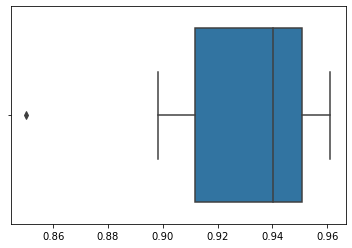

In [38]:
sns.boxplot(acc_list);

In [ ]:
sss = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.1)
batch_size = 32
acc_list = []
for train_index, test_index in sss.split(X, Y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = pd.get_dummies(Y[train_index]).values, pd.get_dummies(Y[test_index]).values
    train_batch_generator = BatchGenerator(x_train, y_train, batch_size=batch_size)
    test_batch_generator = BatchGenerator(x_test, y_test, batch_size=batch_size)
    model = create_model(filters=[16, 32, 128, 128, 32, 8], learning_rate=0.0005, activation="relu", 
                         dropout0=0.5, dropout1=0.3)
    model.fit(x=train_batch_generator, verbose=1, epochs=12)
    

Train for 449 steps
Epoch 1/12
449/449 [==============================] - 118s 262ms/step - loss: 0.9496 - categorical_accuracy: 0.6326
Epoch 2/12
449/449 [==============================] - 119s 265ms/step - loss: 0.6096 - categorical_accuracy: 0.7885
Epoch 3/12
449/449 [==============================] - 116s 257ms/step - loss: 0.4760 - categorical_accuracy: 0.8240
Epoch 4/12
449/449 [==============================] - 117s 262ms/step - loss: 0.4028 - categorical_accuracy: 0.8470
Epoch 5/12
449/449 [==============================] - 119s 265ms/step - loss: 0.3589 - categorical_accuracy: 0.8624
Epoch 6/12
449/449 [==============================] - 118s 262ms/step - loss: 0.3251 - categorical_accuracy: 0.8792
Epoch 7/12
449/449 [==============================] - 120s 266ms/step - loss: 0.2945 - categorical_accuracy: 0.8955
Epoch 8/12
449/449 [==============================] - 341s 760ms/step - loss: 0.2599 - categorical_accuracy: 0.9123
Epoch 9/12
157/449 [=========>....................] 